<a href="https://colab.research.google.com/github/AlirezaAK2000/Digit-Recognition/blob/master/AI_First_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# A function to plot images
def show_image(img):
    image = img.reshape((28, 28))
    plt.imshow(image, 'gray')


In [3]:
train_images_file = open('drive/MyDrive/colab samples/train-images.idx3-ubyte', 'rb')
train_images_file.seek(4)
num_of_train_images = int.from_bytes(train_images_file.read(4), 'big')
train_images_file.seek(16)

train_labels_file = open('drive/MyDrive/colab samples/train-labels.idx1-ubyte', 'rb')
train_labels_file.seek(8)


8

In [4]:
train_set = []
for n in range(num_of_train_images):
    image = np.zeros((784, 1))
    for i in range(784):
        image[i, 0] = int.from_bytes(train_images_file.read(1), 'big') / 256
    
    label_value = int.from_bytes(train_labels_file.read(1), 'big')
    label = np.zeros((10, 1))
    label[label_value, 0] = 1
    
    train_set.append((image, label))



In [5]:
# Reading The Test Set
test_images_file = open('drive/MyDrive/colab samples/t10k-images.idx3-ubyte', 'rb')
test_images_file.seek(4)

test_labels_file = open('drive/MyDrive/colab samples/t10k-labels.idx1-ubyte', 'rb')
test_labels_file.seek(8)

num_of_test_images = int.from_bytes(test_images_file.read(4), 'big')
test_images_file.seek(16)

test_set = []
for n in range(num_of_test_images):
    image = np.zeros((784, 1))
    for i in range(784):
        image[i] = int.from_bytes(test_images_file.read(1), 'big') / 256
    
    label_value = int.from_bytes(test_labels_file.read(1), 'big')
    label = np.zeros((10, 1))
    label[label_value, 0] = 1
    
    test_set.append((image, label))


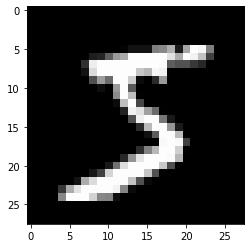

In [6]:
# Plotting an image
show_image(train_set[0][0])
plt.show()

In [7]:
train_set_x_v = np.transpose(np.squeeze(np.array([rec[0] for rec in train_set])))
train_set_x_v.shape
test_set_x_v = np.transpose(np.squeeze(np.array([rec[0] for rec in test_set])))
test_set_x_v.shape

(784, 10000)

In [8]:
train_set_y_v = np.transpose(np.squeeze(np.array([rec[1] for rec in train_set])))
train_set_y_v.shape
test_set_y_v = np.transpose(np.squeeze(np.array([rec[1] for rec in test_set])))
test_set_y_v.shape

(10, 10000)

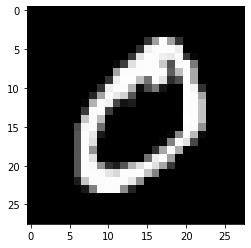

array([0., 0., 0., ..., 0., 0., 0.])

In [9]:
show_image(np.transpose(train_set_x_v[:,1]))
plt.show()
train_set_y_v[1]

In [118]:
def sigmoid(A):
  return 1/(1+np.exp(-1 * A))
def sigmoid_deriv(A):
  sig = sigmoid(A)
  return sig * (1 - sig)

def softmax(A):
  e = np.exp(A)
  return e / np.sum(e)
def relu(A):
  return np.maximum(A , 0)
def relu_deriv(A):
  return (A > 0).astype(int)
def tanh(A):
  return np.tanh(A)
def tanh_deriv(A):
  return 1 - tanh(A) ** 2
def leaky_relu(A,alpha=0.01):
  return np.where(A > 0, A, A * alpha)     
def leaky_relu_deriv(A, alpha=0.01):
  dx = np.ones_like(A)
  dx[A < 0] = alpha
  return dx                     

In [133]:
model = [
    (train_set_x_v.shape[0] , None),
    (16 , relu ,relu_deriv ),
    (16 , relu ,relu_deriv ),
    (10 , sigmoid , sigmoid_deriv),

]
model

In [120]:
np.random.seed(2)
def get_dimensions(model):
  dimensions = [(model[i+1][0], model[i][0]) for i in range(len(model)-1)]
  return dimensions
dimensions = get_dimensions(model)

In [136]:
def initializer(shape ):
  w = np.random.randn(shape[0],shape[1]) * np.sqrt(2./shape[1])
  # b = np.random.randn(shape[0] , 1) * np.sqrt(2./shape[1])
  b = np.zeros((shape[0] , 1))

  return (w , b)

In [137]:
def initialize(model):
  W = []
  B = []
  for shape in dimensions:
    w , b  = initializer(shape)
    assert(w.shape == shape)
    assert(b.shape == (shape[0] , 1))
    W.append(w)
    B.append(b)
  return W , B
W , B = initialize(model)

In [123]:
def mse_cost(y , y_prim):
  return np.sum((y_prim-y)**2)/y.shape[1]

In [124]:
def forward_propagation(X , W , B,model):
  layers_num = len(W)
  A = [X]
  Z = []
  for i in range(layers_num):
    # assert(W[i].shape[1] == X.shape[0])
    z = W[i] @ A[i] + B[i]
    a = model[i + 1][1](z)
    A.append(a)
    Z.append(z)
    # print(z.shape)
  return {
      'A':A,
      'Z':Z
  }

In [125]:
# print(train_set_x_v.shape)
cache = forward_propagation(train_set_x_v , W , B,model)
assert(train_set_y_v.shape == cache['A'][-1].shape)
for i in cache['A']:
  print(i.shape)

(784, 60000)
(16, 60000)
(16, 60000)
(10, 60000)


In [126]:
mse_cost(train_set_y_v,cache['A'][-1])
cache['Z'][0].shape

(16, 60000)

In [127]:
def backward_propagation(W , B , cache, Y , model):
  A , Z = cache['A'] ,cache['Z']
  # print(Z)
  dW , dB= [] , []
  layers_num = len(W)
  tmp = (2 * (A[-1] - Y)) * model[-1][2](Z[-1])
  db = tmp  @ np.ones((A[-1].shape[1],1))
  dw = tmp  @ np.transpose(A[-2])
  dA = [np.transpose(W[-1]) @ tmp]
  assert(dw.shape == W[-1].shape)
  assert(db.shape == B[-1].shape)
  dW.append(dw)
  dB.append(db)
  for i in reversed(range(layers_num - 1)):
    tmp = dA[0] * model[i+1][2](Z[i])
    db = tmp @ np.ones((tmp.shape[1],1))
    dw = tmp @ np.transpose(A[i])
    da = np.transpose(W[i]) @ tmp
    dA.insert(0,da)
    dW.insert(0,dw)
    dB.insert(0,db)
    assert(dw.shape == W[i].shape)
    assert(db.shape == B[i].shape)

  return {
      'dW':dW,
      'dB':dB
  }

In [128]:
a = backward_propagation(W,B, cache,train_set_y_v , model)

In [154]:
from collections import defaultdict
def test(W, B , X ,Y , model):
  cache = forward_propagation(X , W , B , model)
  Y_prim = cache['A'][-1]
  Y_prim = np.round(Y_prim)
  result = defaultdict(lambda : 0,dict(zip(*(np.unique((Y_prim == Y).all(0) , return_counts=True)))))
  return result[True] / (result[True] + result[False]) * 100


def main_model(model , X , Y ,X_test , Y_test , epoch=200 , batch_size=20 , a=1):
  costs , test_accuracies , train_accuracies = [] , [] , []
  num_iteration = X.shape[1]//batch_size
  W , B = initialize(model)
  for i in range(epoch):
    cost = None
    for j in range(num_iteration):
      batch_x = X[:,j*batch_size:(j+1)*batch_size]
      batch_y = Y[:,j*batch_size:(j+1)*batch_size]
      cache = forward_propagation(batch_x , W,B,model)
      cost = mse_cost(batch_y , cache['A'][-1])
      gradients = backward_propagation(W , B , cache , batch_y , model)
      for k in range(len(W)):
        W[k] = W[k] - a * gradients['dW'][k]
        B[k] = B[k] - a * gradients['dB'][k]
    # if i % 10 == 0:
    train_accuracy = test(W , B , X , Y , model)
    test_accuracy = test(W , B , X_test , Y_test , model)
    print(f'*** epoch : {i} ======> cost : {cost} , train accuracy : {train_accuracy} , test accuracy : {test_accuracy}')
    costs.append(cost)
    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)

  train_accuracy = test(W , B , X , Y , model)
  test_accuracy = test(W , B , X_test , Y_test , model)
  print('__________________________________________________')
  print(f"train accuracy: {train_accuracy}")
  print(f"test accuracy: {test_accuracy}")  
  return costs , test_accuracies , train_accuracies



In [156]:
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=100)

*** epoch : 0 ======> cost : 0.0096749268593572 , train accuracy : 85.79166666666667 , test accuracy : 86.03
*** epoch : 1 ======> cost : 0.012766827651325507 , train accuracy : 89.02333333333333 , test accuracy : 88.83
*** epoch : 2 ======> cost : 0.05019297934871295 , train accuracy : 90.84666666666666 , test accuracy : 90.67
*** epoch : 3 ======> cost : 0.0360292679055055 , train accuracy : 91.545 , test accuracy : 91.03999999999999
*** epoch : 4 ======> cost : 0.018425360370736096 , train accuracy : 92.08833333333334 , test accuracy : 91.56
*** epoch : 5 ======> cost : 0.00276526334698659 , train accuracy : 92.63666666666667 , test accuracy : 91.94
*** epoch : 6 ======> cost : 0.0065593417641864535 , train accuracy : 92.58833333333332 , test accuracy : 91.55
*** epoch : 7 ======> cost : 0.003640950191315723 , train accuracy : 93.00666666666667 , test accuracy : 91.69
*** epoch : 8 ======> cost : 0.004705209282176558 , train accuracy : 93.26666666666667 , test accuracy : 92.0
*** ep

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


*** epoch : 78 ======> cost : 0.0004402893565312275 , train accuracy : 95.05166666666666 , test accuracy : 93.53
*** epoch : 79 ======> cost : 0.0020930338658555663 , train accuracy : 95.85833333333333 , test accuracy : 94.35
*** epoch : 80 ======> cost : 0.0020597524150854736 , train accuracy : 95.395 , test accuracy : 93.73
*** epoch : 81 ======> cost : 0.008325993983647629 , train accuracy : 95.61 , test accuracy : 93.86
*** epoch : 82 ======> cost : 0.00017942061843225862 , train accuracy : 95.45333333333333 , test accuracy : 93.78999999999999
*** epoch : 83 ======> cost : 0.0013768624639398368 , train accuracy : 95.51666666666667 , test accuracy : 93.66
*** epoch : 84 ======> cost : 0.004815890525199618 , train accuracy : 95.33 , test accuracy : 93.61
*** epoch : 85 ======> cost : 0.0009785074962554764 , train accuracy : 95.51833333333335 , test accuracy : 93.84
*** epoch : 86 ======> cost : 0.012958076803378214 , train accuracy : 96.01166666666666 , test accuracy : 94.21000000000

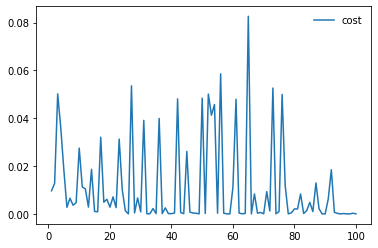

In [160]:
plt.plot([i for i in range(1,len(info[0])+1)] , info[0] , label='cost')
plt.legend(loc="upper right", frameon=False)
plt.show()

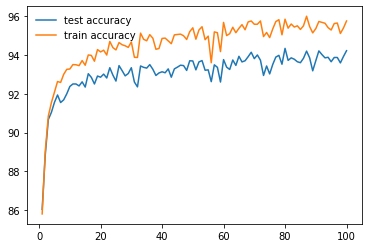

In [163]:
plt.plot([i for i in range(1,len(info[1])+1)] , info[1] , label='test accuracy')
plt.plot([i for i in range(1,len(info[2])+1)] , info[2] , label='train accuracy')
plt.legend(loc="upper left", frameon=False)
plt.show()